# 과제 : Kannada digits 분류하기

[링크](https://www.kaggle.com/c/tobigs15-mnist-competition/overview/description)

# 데이터셋 확인하기
colab gpu 환경에서 작업되었으므로, 구글 드라이브에서 파일을 불러온다.

In [1]:
!unzip -q -d data /content/drive/MyDrive/Datasets/tobigs15-mnist-competition.zip

이후 전이학습에서 사용한 모델의 크기가 매우 크기 때문에 GPU 메모리 초과가 발생하여, TPU를 사용했다.

아래 패키지는 TPU를 사용하기 위한 패키지이다.

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [2]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('data/train_df.csv')
test_data = pd.read_csv('data/test_df.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [4]:
print(f"len of train_data : {len(train_data)}, shape: {train_data.shape}")
print(f"len of test_data : {len(test_data)}, shape: {test_data.shape}")
print(f"len of submission_data : {len(sample_submission)}, shape: {sample_submission.shape}")

len of train_data : 42000, shape: (42000, 785)
len of test_data : 18000, shape: (18000, 785)
len of submission_data : 18000, shape: (18000, 2)


train 데이터의 경우는 28 * 28 픽셀인 (784) 사이즈에 더해 1개의 feature가 더 있었다. 또한 총 데이터 42000개로 이루어져 있다.

test 데이터의 경우는 같은 피쳐 사이즈지만 총 18000개의 데이터로 이루어져 있다.

In [ ]:
train_data.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


추가로 들어있는 1개의 feature 는 label 이었다.

In [ ]:
# 제출 형식 확인
sample_submission.head()

,Id,Category
0,57808,0
1,4960,0
2,35755,0
3,15543,0
4,48968,0


In [ ]:
test_data.head(1)

,Unnamed: 0,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,57808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


제출용 데이터에도 Unnamed:0 이라는 인덱스 데이터가 있는 것을 볼 수 있다.

In [43]:
# 데이터 분할
X = train_data.drop('label', axis=1).values
y = train_data['label'].values

Xt = test_data.iloc[:, 1:].values

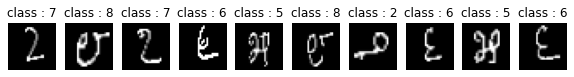

In [ ]:
# 체크

pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(X[i].reshape(28, 28), cmap='gray')
  plt.title(f"class : {y[i]}")

# Pytorch

파이토치를 이용해서 과제를 수행해 보았다.

In [10]:
# 패키지 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [11]:
# TPU사용시 임포트
# import torch_xla
# import torch_xla.core.xla_model as xm

In [12]:
# TPU를 DEVICE에 설정
# DEVICE = xm.xla_device()

In [13]:
# 하이퍼파라미터 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
EPOCHS=50

In [ ]:
print(f"Using {DEVICE} on train & evauation")

### 데이터 증강

데이터에 특정 연산을 가해서 데이터의 수를 증가시키는 방법이다.

학습용 데이터에 적용된 변형은 다음과 같다.
- Normalize : 평균과 표준편차를 각각 0.5로 정규화했다.
- RandomRotation : 이미지에 랜덤하게 45도 회전을 가한다.
- RandomAffine : 이미지에 랜덤하게 어파인 변형을 가한다. 어파인 변형이란, 데이터의 이동, 회전, 크기 변환을 모두 포함한다.

어파인 변형의 표현식은 다음 식이다.
![어파인](https://t1.daumcdn.net/cfile/tistory/254B523951D959D702)

In [14]:
# 데이터 증강을 위해 trans 정의
train_trans = transforms.Compose([
                            transforms.Resize(224),
                            transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                            transforms.RandomRotation(degrees=45),
                            transforms.Normalize(mean=(0.5,), std=(0.5,))

])


val_trans = transforms.Compose([
                            transforms.Resize(224),
                            transforms.Normalize(mean=(0.5,), std=(0.5,))

])

데이터셋을 25퍼센트의 비중으로 분리한다.

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=42)

In [15]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

데이터 증강을 정의한 데이터로더를 정의한다.

In [10]:
# 데이터를 입력하는 DataLoader 정의
train_dataset = MyDataset(X_train.reshape(-1, 1, 28, 28), y_train, train_trans)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MyDataset(X_val.reshape(-1, 1, 28, 28), y_val, val_trans)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

x : torch.Size([32, 1, 224, 224]), y: torch.Size([32])


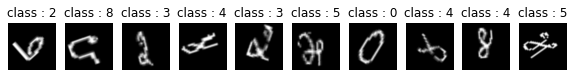

In [16]:
# Augmentation 된 데이터를 확인한다.
for x, y in train_dataloader:

  print(f"x : {x.shape}, y: {y.shape}")
  pltsize = 1
  plt.figure(figsize = (10 * pltsize, pltsize))

  for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(x[i].reshape(224, 224), cmap='gray')
    plt.title(f"class : {y[i]}")

  
  break

## 전이학습 실시

이미 학습된 유명한 모델의 가중치를 가져와서 훈련하면 높은 훈련 정확도를 달성할 수 있다.

### 학습 결과 모델별 정확도는 다음과 같았다.
- vgg16 : 98%
- denseNet(resNet의 확장) : 95%
- vgg19 + Batch Normalization + Image augmentation : 99.2%

In [6]:
import torchvision.models

VGG19 모델을 불러와 사용했다.

In [7]:
model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
  param.requires_grad = False # 학습 불가 상태로 맞춤

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [16]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.BatchNorm1d(4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.BatchNorm1d(4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)

In [17]:
stacked_model = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    model
)

가중치 초기화도 적용해 보았으나, 적용하지 않은 경우에 비해 성능이 1%정도 하락하는 경향이 있어서 이번에는 사용하지 않았다.

In [16]:
# # 적용하지 않는게 살짝 높게 나오는 경향이 있어서 적용하지 않음.
# import torch.nn.init as init
# def weight_init(m):
#   if isinstance(m, nn.Linear):
#     init.kaiming_uniform_(m.weight.data)

# stacked_model.apply

In [44]:
# 미리 학습된 모델 불러오기 (이어하기)
stacked_model.load_state_dict(torch.load("/content/drive/MyDrive/trained_model/kannada_MNIST2.pt"))

<All keys matched successfully>

In [18]:
stacked_model.to(DEVICE)

Sequential(
  (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size

In [17]:
optimizer = torch.optim.Adam(stacked_model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [27]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()

    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print(f"Epoch: {Epoch} Data: [{batch_idx * len(image)} / {len(train_loader.dataset)}] Loss: {loss.item():0.6f}")
  

In [28]:
def evaluate(model, test_loader, best_accuracy):
  model.eval()
  test_loss = 0
  correct = 0
  

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)

      output= model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100 * correct / len(test_loader.dataset)

  
  if best_accuracy == None or test_accuracy >= best_accuracy:
    torch.save(model.state_dict(), "/content/drive/MyDrive/trained_model/kannada_MNIST2.pt")
    best_accuracy = test_accuracy
    print("Model saved")
  test_acc.append(test_accuracy)
  test_ls.append(test_loss)

  print(f"Test Epoch: {Epoch} Accuracy: {test_accuracy:0.6f}, Loss: {test_loss:.6f}")

  return best_accuracy

### 학습률 감소
learning rate decay를 사용하여, 5에폭 학습시마다 학습률에 0.1을 곱해 감소시켰다.

In [62]:
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [62]:
test_acc = []
test_ls = []
best_accuracy = 0


In [ ]:
for Epoch in range(1, EPOCHS+1):
  train(stacked_model, train_dataloader, optimizer, 100)
  best_accuracy = evaluate(stacked_model, val_dataloader, best_accuracy)
  exp_lr_scheduler.step()

### 제출용 데이터 생성 및 확인

In [89]:
test_dataset = MyDataset((Xt).reshape(-1, 1, 28, 28), y_train, val_trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [57]:
output = None
model.eval()
with torch.no_grad():
    for image, label in test_dataloader:
      image = image.to(DEVICE)
      if output is None:
        output = torch.argmax(stacked_model(image), dim=1).cpu().numpy()
      else:
        output = np.concatenate([output, torch.argmax(stacked_model(image), dim=1).cpu().numpy()], axis=0)


In [50]:
output

array([8, 0, 5, ..., 3, 4, 1])

In [58]:
table = pd.DataFrame({'id': test_data.iloc[:, 0], 'Category': output})
# table
table.to_csv('/content/drive/MyDrive/answer.csv', index=False)

# 학습 과정 플롯

가장 정확도가 높았던 모델을 기준으로 학습 정확도를 표시해 보았다.

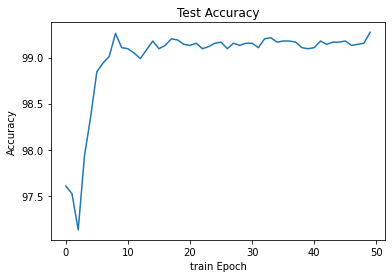

In [ ]:
plt.title("Test Accuracy")
plt.plot(np.arange(0,len(test_acc)), test_acc)
plt.xlabel("train Epoch")
plt.ylabel("Accuracy")
plt.show()

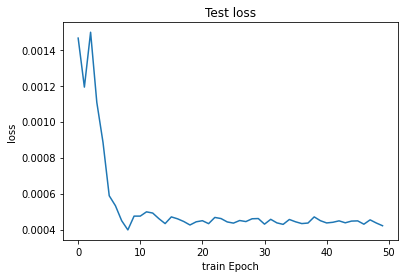

In [ ]:
plt.title("Test loss")
plt.plot(np.arange(0,len(test_ls)), test_ls)
plt.xlabel("train Epoch")
plt.ylabel("loss")
plt.show()

### 나중을 위한 그래프 저장

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/lossGraph.csv')

In [ ]:
df = pd.DataFrame({'acc_vgg16_bn': test_acc, 'loss_vgg16_bn': test_ls})

In [ ]:
# df.to_csv('/content/drive/MyDrive/lossGraph.csv', index=False)

# Pseudo Labeling

정확도를 올리는 방법 중 하나로는 Pseudo Labeling 이 있다.

Label이 없는 데이터에 충분히 학습된 모델을 이용해 Labeling을 수행한 뒤 이를 다시 학습 데이터에 넣어 학습을 수행한다.

In [28]:
def pseudo_train(model, train_loader, optimizer, test_dataloader, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()

    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print(f"Epoch: {Epoch} Data: [{batch_idx * len(image)} / {len(train_loader.dataset)}] Loss: {loss.item():0.6f}")

  print("make pseudo_label")
  pseudo_output = None
  model.eval()
  with torch.no_grad():
      for image, label in test_dataloader:
        image = image.to(DEVICE)
        if pseudo_output is None:
          pseudo_output = torch.argmax(stacked_model(image), dim=1).cpu().numpy()
        else:
          pseudo_output = np.concatenate([pseudo_output, torch.argmax(stacked_model(image), dim=1).cpu().numpy()], axis=0)

  pseudo_y = np.concatenate([y_train, pseudo_output], axis=0)

  pseudo_dataset = MyDataset(pseudo_X.reshape(-1, 1, 28, 28), pseudo_y, train_trans)
  pseudo_dataloader = torch.utils.data.DataLoader(pseudo_dataset, batch_size=BATCH_SIZE, shuffle=True)

    
  return pseudo_dataloader

In [21]:
BATCH_SIZE = 128
EPOCHS = 20

제출된 답안 파일을 pseudo-label로 사용한다. 정확도가 99% 이상이 나온 것이기 때문에 사용해도 문제 없다.

In [22]:
old_answer = pd.read_csv('/content/drive/MyDrive/answer.csv') # 99.2% 로 튜닝된 데이터 불러옴
pseudo_label = old_answer['Category'].values

원래는 따로 gradient 를 계산해야 하나, 메모리 부족 이슈가 발생하여 라벨링된 데이터와 의사라벨링 데이터의 비중을 같게 두었다.

이렇게 되면, 두 배열을 concatenate 해서 하나의 데이터로더로 사용할 수 있게 된다.

In [23]:
pseudo_X = np.concatenate([X_train, Xt], axis=0)
pseudo_y = np.concatenate([y_train, pseudo_label], axis=0)

In [24]:
pseudo_dataset = MyDataset(pseudo_X.reshape(-1, 1, 28, 28), pseudo_y, train_trans)
pseudo_dataloader = torch.utils.data.DataLoader(pseudo_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MyDataset((Xt).reshape(-1, 1, 28, 28), y_train, val_trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
poptimizer = torch.optim.Adam(stacked_model.parameters(), lr = 0.01)
pcriterion = nn.CrossEntropyLoss()

from torch.optim import lr_scheduler
pexp_lr_scheduler = lr_scheduler.StepLR(poptimizer, step_size=5, gamma=0.1)

의사레이블 데이터까지 포함하여 학습을 진행했다.

다른 방법은 모두 같기 때문에 이전에 작성했던 학습 함수에 데이터로더만 바꿔서 사용할 수 있다.

In [26]:
test_acc = []
test_ls = []
best_accuracy = 0

In [40]:
for Epoch in range(1, EPOCHS+1):
  pseudo_dataloader = pseudo_train(stacked_model, pseudo_dataloader, poptimizer, test_dataloader, 100)
  best_accuracy = evaluate(stacked_model, val_dataloader, best_accuracy)
  pexp_lr_scheduler.step()

Epoch: 1 Data: [0 / 49500] Loss: 0.006138
Epoch: 1 Data: [12800 / 49500] Loss: 0.017869
Epoch: 1 Data: [25600 / 49500] Loss: 0.018672
Epoch: 1 Data: [38400 / 49500] Loss: 0.016310
make pseudo_label
Test Epoch: 1 Accuracy: 99.057143, Loss: 0.001037
Epoch: 2 Data: [0 / 49500] Loss: 0.038815
Epoch: 2 Data: [12800 / 49500] Loss: 0.025288
Epoch: 2 Data: [25600 / 49500] Loss: 0.071264
Epoch: 2 Data: [38400 / 49500] Loss: 0.026958
make pseudo_label
Test Epoch: 2 Accuracy: 99.038095, Loss: 0.001021
Epoch: 3 Data: [0 / 49500] Loss: 0.017920
Epoch: 3 Data: [12800 / 49500] Loss: 0.029265
Epoch: 3 Data: [25600 / 49500] Loss: 0.007184
Epoch: 3 Data: [38400 / 49500] Loss: 0.010651
make pseudo_label
Test Epoch: 3 Accuracy: 99.047619, Loss: 0.001058
Epoch: 4 Data: [0 / 49500] Loss: 0.026349
Epoch: 4 Data: [12800 / 49500] Loss: 0.003178
Epoch: 4 Data: [25600 / 49500] Loss: 0.067224
Epoch: 4 Data: [38400 / 49500] Loss: 0.046249
make pseudo_label
Test Epoch: 4 Accuracy: 99.009524, Loss: 0.001044
Epoch: 5

KeyboardInterrupt: ignored

적용 결과 너무 많이 학습한 경우 정확도가 오히려 떨어지는 모습을 보였다.

# Unfair Method

[Kaggle](https://www.kaggle.com/tonysun94/pytorch-1-0-1-on-mnist-acc-99-8) 에서 참고한 방법.

테스트 데이터가 아닌 더 많은 데이터로 예측할 수 있다.

컴페티션 데이터가 아니라 외부 데이터를 사용한 것이기 때문에 공정하지 못한 방법으로 설명하고 있다.


In [22]:
new_X_train = np.load('/content/drive/MyDrive/Datasets/Kannada_MNIST/X_kannada_MNIST_train.npz')
new_y_train = np.load('/content/drive/MyDrive/Datasets/Kannada_MNIST/y_kannada_MNIST_train.npz')

new_X_val = np.load('/content/drive/MyDrive/Datasets/Kannada_MNIST/X_kannada_MNIST_test.npz')
new_y_val = np.load('/content/drive/MyDrive/Datasets/Kannada_MNIST/y_kannada_MNIST_test.npz')

In [23]:
new_X_train = new_X_train['arr_0']
new_y_train = new_y_train['arr_0']
new_X_val = new_X_val['arr_0']
new_y_val = new_y_val['arr_0']

In [97]:
# 데이터를 입력하는 DataLoader 정의
new_train_dataset = MyDataset(new_X_train.reshape(-1, 1, 28, 28), new_y_train, train_trans)
new_train_dataloader = torch.utils.data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

new_val_dataset = MyDataset(new_X_val.reshape(-1, 1, 28, 28), new_y_val, val_trans)
new_val_dataloader = torch.utils.data.DataLoader(new_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
optimizer = torch.optim.Adam(stacked_model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [30]:
test_acc = []
test_ls = []
best_accuracy = 0

In [ ]:
for Epoch in range(0, 40):
  train(stacked_model, new_train_dataloader, optimizer, 100)
  best_accuracy = evaluate(stacked_model, new_val_dataloader, best_accuracy)
  exp_lr_scheduler.step()

학습 결과 기존 정확도보다 높은 정확도를 달성하는 것을 확인했다.

99.5% 정도의 정확도가 나오며, 학습이 진행될 때마다 정확도가 올라가는 것으로 보아, 시간만 있으면 상당한 정확도를 달성할 것으로 보인다.

# 기초적인 CNN

In [99]:
# 모듈 정의
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm1d(120)
        self.bn4 = nn.BatchNorm1d(84)
  


    def forward(self, x):
        # (2, 2) 크기 윈도우에 대해 맥스 풀링(max pooling)
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 배치 차원을 제외한 모든 차원
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = CNN()
print(net)


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [100]:
net.to(DEVICE)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [101]:
# 데이터 증강을 위해 trans 정의
train_trans = transforms.Compose([
                            transforms.Resize(32),
                            transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                            transforms.RandomRotation(degrees=45),
                            transforms.Normalize(mean=(0.5,), std=(0.5,))

])


val_trans = transforms.Compose([
                            transforms.Resize(32),
                            transforms.Normalize(mean=(0.5,), std=(0.5,))

])

In [78]:
# 데이터를 입력하는 DataLoader 정의
train_dataset = MyDataset(X_train.reshape(-1, 1, 28, 28), y_train, train_trans)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MyDataset(X_val.reshape(-1, 1, 28, 28), y_val, val_trans)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [103]:
test_acc = []
test_ls = []
best_accuracy = 0

In [92]:
for Epoch in range(1, EPOCHS+1):
  train(net, train_dataloader, optimizer, 100)
  best_accuracy = evaluate(net, val_dataloader, best_accuracy)
  exp_lr_scheduler.step()

Epoch: 1 Data: [0 / 31500] Loss: 0.085152
Epoch: 1 Data: [12800 / 31500] Loss: 0.064232
Epoch: 1 Data: [25600 / 31500] Loss: 0.042523
Test Epoch: 1 Accuracy: 99.019048, Loss: 0.000242
Epoch: 2 Data: [0 / 31500] Loss: 0.079983
Epoch: 2 Data: [12800 / 31500] Loss: 0.090997
Epoch: 2 Data: [25600 / 31500] Loss: 0.054462
Test Epoch: 2 Accuracy: 99.000000, Loss: 0.000262
Epoch: 3 Data: [0 / 31500] Loss: 0.090084
Epoch: 3 Data: [12800 / 31500] Loss: 0.077518
Epoch: 3 Data: [25600 / 31500] Loss: 0.084770
Test Epoch: 3 Accuracy: 98.952381, Loss: 0.000272
Epoch: 4 Data: [0 / 31500] Loss: 0.096782
Epoch: 4 Data: [12800 / 31500] Loss: 0.113146
Epoch: 4 Data: [25600 / 31500] Loss: 0.083382
Test Epoch: 4 Accuracy: 98.876190, Loss: 0.000283
Epoch: 5 Data: [0 / 31500] Loss: 0.139702
Epoch: 5 Data: [12800 / 31500] Loss: 0.089759
Epoch: 5 Data: [25600 / 31500] Loss: 0.080697
Test Epoch: 5 Accuracy: 98.971429, Loss: 0.000265
Epoch: 6 Data: [0 / 31500] Loss: 0.116378
Epoch: 6 Data: [12800 / 31500] Loss: 0

KeyboardInterrupt: ignored

In [86]:
net.load_state_dict(torch.load("/content/drive/MyDrive/trained_model/kannada_MNIST2.pt"))

<All keys matched successfully>

In [90]:
output = None
model.eval()
with torch.no_grad():
    for image, label in test_dataloader:
      image = image.to(DEVICE)
      if output is None:
        output = torch.argmax(net(image), dim=1).cpu().numpy()
      else:
        output = np.concatenate([output, torch.argmax(net(image), dim=1).cpu().numpy()], axis=0)

In [91]:
table = pd.DataFrame({'id': test_data.iloc[:, 0], 'Category': output})
# table
table.to_csv('/content/drive/MyDrive/answer.csv', index=False)

In [ ]:
for Epoch in range(0, 40):
  train(net, new_train_dataloader, optimizer, 100)
  best_accuracy = evaluate(net, new_val_dataloader, best_accuracy)
  exp_lr_scheduler.step()

Epoch: 0 Data: [0 / 60000] Loss: 2.354891
Epoch: 0 Data: [12800 / 60000] Loss: 0.387120
Epoch: 0 Data: [25600 / 60000] Loss: 0.333898
Epoch: 0 Data: [38400 / 60000] Loss: 0.220968
Epoch: 0 Data: [51200 / 60000] Loss: 0.245726
Model saved
Test Epoch: 0 Accuracy: 91.230000, Loss: 0.002215
Epoch: 1 Data: [0 / 60000] Loss: 0.155685
Epoch: 1 Data: [12800 / 60000] Loss: 0.161837
Epoch: 1 Data: [25600 / 60000] Loss: 0.097219
Epoch: 1 Data: [38400 / 60000] Loss: 0.195229
Epoch: 1 Data: [51200 / 60000] Loss: 0.125479
Model saved
Test Epoch: 1 Accuracy: 92.500000, Loss: 0.001982
Epoch: 2 Data: [0 / 60000] Loss: 0.172126
Epoch: 2 Data: [12800 / 60000] Loss: 0.200635
Epoch: 2 Data: [25600 / 60000] Loss: 0.110594
Epoch: 2 Data: [38400 / 60000] Loss: 0.214496
Epoch: 2 Data: [51200 / 60000] Loss: 0.150063
Model saved
Test Epoch: 2 Accuracy: 94.420000, Loss: 0.001530
Epoch: 3 Data: [0 / 60000] Loss: 0.105373
Epoch: 3 Data: [12800 / 60000] Loss: 0.147776
Epoch: 3 Data: [25600 / 60000] Loss: 0.044886
Ep

학습 결과 90%의 정확도를 가지는 것을 확인했다.